<a href="https://colab.research.google.com/github/MuhammadIrzam447/visionCodes/blob/master/Test_T_SNE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# New Section

In [ ]:
import os
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [ ]:
# Set device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Define the path to your saved model
save_dir = "/content/Model/Models-Train-03/"
load_path = os.path.join(save_dir, "13_model.pth")

# Load the saved model
resnet = torchvision.models.resnet101(pretrained=False)
resnet.fc = nn.Linear(2048, 2)  # Adjust based on your model's output classes
resnet.load_state_dict(torch.load(load_path))
resnet.to(device)
resnet.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# Define validation data transforms
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class ValidationDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.dataset = datasets.ImageFolder(data_dir, transform=val_transform)
        self.classes = sorted(os.listdir(data_dir))
        self.class_lengths = self._compute_class_lengths()

    def _compute_class_lengths(self):
        class_lengths = {cls: 0 for cls in self.classes}

        for cls in self.classes:
            cls_dir = os.path.join(self.data_dir, cls)
            if os.path.isdir(cls_dir):
                class_lengths[cls] = len(os.listdir(cls_dir))

        return class_lengths

    def __getitem__(self, index):
        image, label = self.dataset[index]
        return image, label

    def __len__(self):
        return len(self.dataset)

In [ ]:
from torch.utils.data import DataLoader, Dataset  # Make sure to import Dataset
from torchvision import datasets  # Import datasets from torchvision

# Create a ValidationDataset instance
valPath = "/content/hateful-train+test_unseen/test"
val_dataset = ValidationDataset(valPath)  # Make sure you define the ValidationDataset class

In [ ]:
# Create a DataLoader for validation data
batch_size = 32  # Adjust as needed
validation_data_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
# Extract latent embeddings
latent_embeddings = []
actual_labels = []

penultimate_layer = nn.Sequential(*list(resnet.children())[:-2]).to(device)

print(penultimate_layer)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [ ]:
with torch.no_grad():
    for images, labels in validation_data_loader:
        images = images.to(device)

        # Get the penultimate layer's output (before the final classification layer)
        embeddings = penultimate_layer(images)
        print(embeddings.shape)
        embeddings = embeddings.view(embeddings.size(0), -1)  # Flatten the embeddings
        print(embeddings.shape)
        latent_embeddings.extend(embeddings.cpu().numpy())
        actual_labels.extend(labels.tolist())

torch.Size([32, 2048, 7, 7])
torch.Size([32, 100352])
torch.Size([32, 2048, 7, 7])
torch.Size([32, 100352])
torch.Size([32, 2048, 7, 7])
torch.Size([32, 100352])
torch.Size([32, 2048, 7, 7])
torch.Size([32, 100352])
torch.Size([32, 2048, 7, 7])
torch.Size([32, 100352])
torch.Size([32, 2048, 7, 7])
torch.Size([32, 100352])
torch.Size([32, 2048, 7, 7])
torch.Size([32, 100352])
torch.Size([32, 2048, 7, 7])
torch.Size([32, 100352])
torch.Size([32, 2048, 7, 7])
torch.Size([32, 100352])
torch.Size([32, 2048, 7, 7])
torch.Size([32, 100352])
torch.Size([32, 2048, 7, 7])
torch.Size([32, 100352])
torch.Size([32, 2048, 7, 7])
torch.Size([32, 100352])
torch.Size([32, 2048, 7, 7])
torch.Size([32, 100352])
torch.Size([32, 2048, 7, 7])
torch.Size([32, 100352])
torch.Size([32, 2048, 7, 7])
torch.Size([32, 100352])
torch.Size([32, 2048, 7, 7])
torch.Size([32, 100352])
torch.Size([32, 2048, 7, 7])
torch.Size([32, 100352])
torch.Size([32, 2048, 7, 7])
torch.Size([32, 100352])
torch.Size([32, 2048, 7, 7])

In [ ]:
latent_embeddings.shape


(2000, 100352)

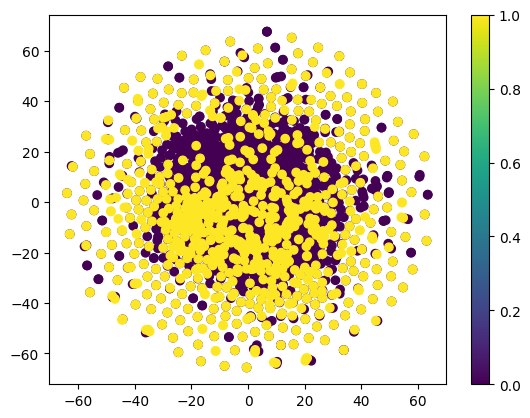

In [ ]:
import numpy as np

latent_embeddings = np.array(latent_embeddings)

# Apply t-SNE to the latent embeddings
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_embeddings = tsne.fit_transform(latent_embeddings)

# Visualization using matplotlib
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=actual_labels, cmap='viridis')
plt.colorbar()
plt.show()

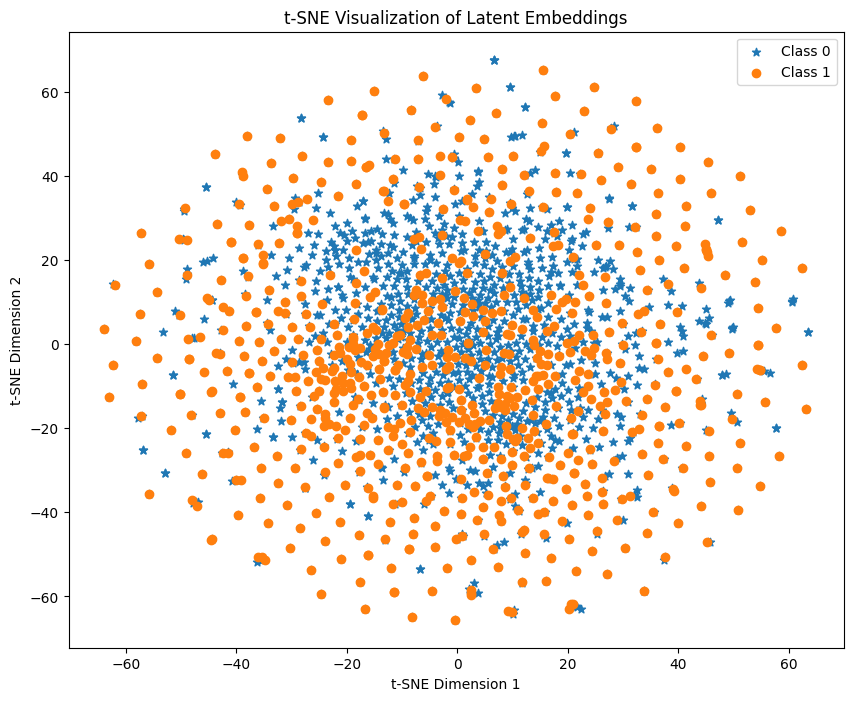

In [ ]:
import os
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# ... (loading model, defining transforms, creating DataLoader, and extracting embeddings)

# Apply t-SNE to the latent embeddings
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_embeddings = tsne.fit_transform(latent_embeddings)

# Get unique class labels from actual_labels
unique_labels = np.unique(actual_labels)

# Create a dictionary to map class labels to markers
label_to_marker = {label: marker for label, marker in zip(unique_labels, ['*', 'o'])}

# Visualization using matplotlib
plt.figure(figsize=(10, 8))

for i, label in enumerate(unique_labels):
    indices = np.where(np.array(actual_labels) == label)[0]
    marker = label_to_marker[label]
    plt.scatter(tsne_embeddings[indices, 0], tsne_embeddings[indices, 1], label=f'Class {label}', marker=marker)

plt.legend()
plt.title('t-SNE Visualization of Latent Embeddings')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()


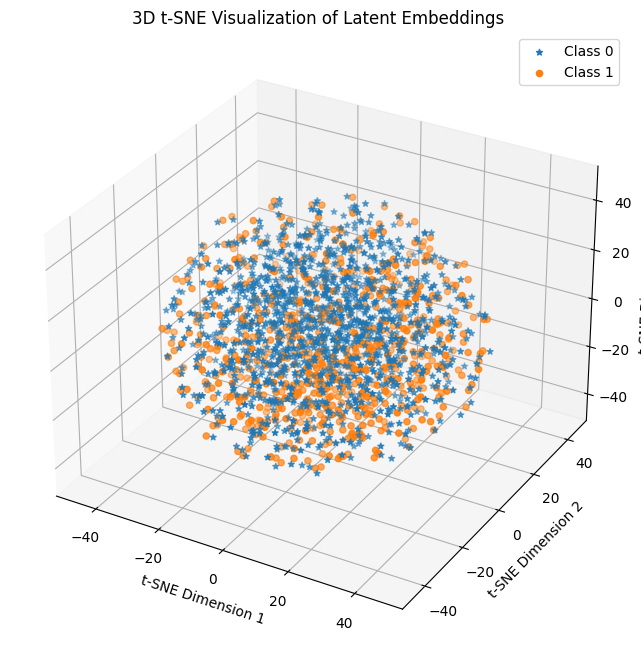

In [ ]:
import os
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Import for 3D plotting
from PIL import Image
import numpy as np

# ... (loading model, defining transforms, creating DataLoader, and extracting embeddings)

# Apply t-SNE to the latent embeddings
tsne = TSNE(n_components=3, perplexity=30, random_state=42)
tsne_embeddings = tsne.fit_transform(latent_embeddings)

# Get unique class labels from actual_labels
unique_labels = np.unique(actual_labels)

# Create a dictionary to map class labels to markers
label_to_marker = {label: marker for label, marker in zip(unique_labels, ['*', 'o'])}

# Visualization using matplotlib 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for i, label in enumerate(unique_labels):
    indices = np.where(np.array(actual_labels) == label)[0]
    marker = label_to_marker[label]
    ax.scatter(tsne_embeddings[indices, 0], tsne_embeddings[indices, 1], tsne_embeddings[indices, 2], label=f'Class {label}', marker=marker)

ax.legend()
ax.set_title('3D t-SNE Visualization of Latent Embeddings')
ax.set_xlabel('t-SNE Dimension 1')
ax.set_ylabel('t-SNE Dimension 2')
ax.set_zlabel('t-SNE Dimension 3')
plt.show()


In [ ]:
import os
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# ... (loading model, defining transforms, creating DataLoader)

# Extract embeddings from the last fully connected layer
last_fc_layer = resnet.fc  # Assuming the fc layer is the last layer of your model
latent_embeddings = []
actual_labels = []

with torch.no_grad():
    for images, labels in validation_data_loader:
        images = images.to(device)

        # Get the embeddings from the last fully connected layer
        embeddings = last_fc_layer(images)
        print(embeddings.shape)
        latent_embeddings.extend(embeddings.cpu().numpy())
        actual_labels.extend(labels.tolist())

latent_embeddings = np.array(latent_embeddings)
print(latent_embeddings.shape)

# Apply t-SNE to the latent embeddings
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_embeddings = tsne.fit_transform(latent_embeddings)

# Visualization using matplotlib
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=actual_labels, cmap='viridis')
plt.colorbar()
plt.show()


In [ ]:
import os
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Import for 3D plotting
from PIL import Image
import numpy as np

# ... (loading model, defining transforms, creating DataLoader, and extracting embeddings)

# Apply t-SNE to the latent embeddings
tsne = TSNE(n_components=3, perplexity=30, random_state=42)
tsne_embeddings = tsne.fit_transform(latent_embeddings)

# Get unique class labels from actual_labels
unique_labels = np.unique(actual_labels)

# Create a dictionary to map class labels to markers
label_to_marker = {label: marker for label, marker in zip(unique_labels, ['*', 'o'])}

# Visualization using matplotlib 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for i, label in enumerate(unique_labels):
    indices = np.where(np.array(actual_labels) == label)[0]
    marker = label_to_marker[label]
    ax.scatter(tsne_embeddings[indices, 0], tsne_embeddings[indices, 1], tsne_embeddings[indices, 2], label=f'Class {label}', marker=marker)

ax.legend()
ax.set_title('3D t-SNE Visualization of Latent Embeddings')
ax.set_xlabel('t-SNE Dimension 1')
ax.set_ylabel('t-SNE Dimension 2')
ax.set_zlabel('t-SNE Dimension 3')
plt.show()


# Hateful Memes

In [1]:
import os

root_directory = "/content/hateful-train+test_unseen/test"
output_file = "/content/hateful-train+test_unseen/file_paths.txt"

file_paths = []

# Walk through the directory and its subdirectories
for dirpath, dirnames, filenames in os.walk(root_directory):
    for filename in filenames:
        file_paths.append(os.path.join(dirpath, filename))

# Save the file paths to the output text file
with open(output_file, "w") as f:
    for path in file_paths:
        f.write(path + "\n")

print(f"File paths saved to {output_file}")


File paths saved to /content/hateful-train+test_unseen/file_paths.txt


In [ ]:
from torchvision.models import resnet101
import os
import torch
import torchvision.transforms as transforms
from PIL import Image

os.environ["CUDA_VISIBLE_DEVICES"] = "0"


def process_image(image):
    transform = transforms.Compose(
        [transforms.Resize(256),
         transforms.CenterCrop(224),
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])
            ,
         transforms.Lambda(lambda imgt: imgt.unsqueeze(0))
         ])
    image = transform(image)
    return image


model = resnet101(pretrained=True)
modules = list(model.children())[:-2]
model = torch.nn.Sequential(*modules)
model.eval()

def pil_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

def get_vector(image_name):
    img = process_image(pil_loader(image_name))
    t_img = img[0].unsqueeze(0)
    feats = model(t_img)
    feats = torch.nn.AdaptiveAvgPool2d((1, 1))(feats)
    feats = feats.view(feats.shape[0], feats.shape[1], -1)
    feats = feats.permute(0, 2, 1).squeeze(0)
    return feats

img_lst = []
label_list = []
feat_lst =[]

txt_file_path = '/content/hateful-train+test_unseen/file_paths.txt'

trainFile = open(txt_file_path, 'r')
train_lines = trainFile.readlines()


for train_line in train_lines:
    img_lst.append(train_line.rsplit()[0])
    label_list.append(train_line.split("/")[-2])


for index, simg in enumerate(img_lst):
    print("Image No.",index)
    test_embedding = get_vector(simg)
    feat_lst.append(test_embedding.tolist()[0])

with open('/content/hateful-train+test_unseen/test.csv', 'w') as w_file:
    for idx, line in enumerate(feat_lst):
        for ind_val in line:
            ind = str(ind_val) + ','
            w_file.write(ind)
        w_file.write(str(label_list[idx]))
        w_file.write('\n')
w_file.close()


In [1]:
import pandas as pd
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

features_file = '/content/hateful-train+test_unseen/test.csv'
feats = pd.read_csv(features_file, header=None).values

image_paths_file = '/content/hateful-train+test_unseen/file_paths.txt'
with open(image_paths_file, 'r') as f:
    image_paths = [line.strip() for line in f]

labels = [int(path.split('/')[-2]) for path in image_paths]
labels_encoded = preprocessing.LabelEncoder().fit_transform(labels)

In [2]:
print(labels_encoded)

[1 1 1 ... 0 0 0]


In [3]:
# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(feats, labels_encoded, test_size=0.2, random_state=42)

# SVM Classification
model = SVC(kernel='linear')
model.fit(x_train, y_train)
pred = model.predict(x_test)
accuracy = metrics.accuracy_score(y_test, pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 1.00


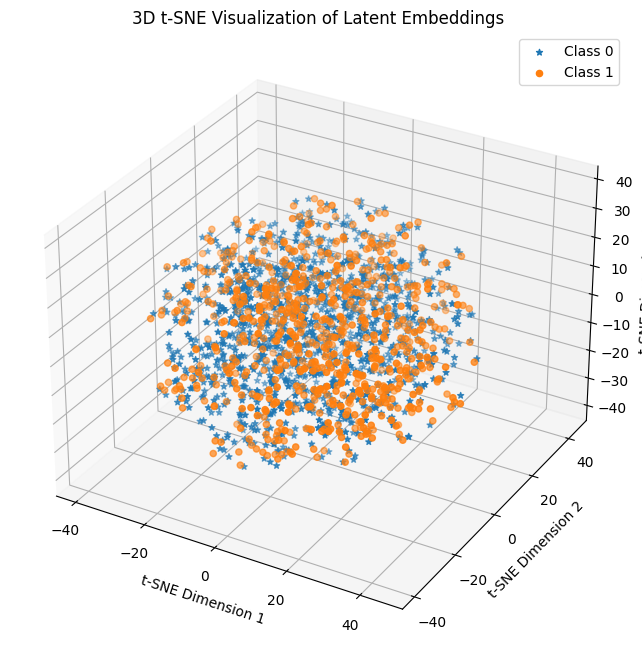

In [4]:
import os
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Import for 3D plotting
from PIL import Image
import numpy as np

# Apply t-SNE to the latent embeddings
tsne = TSNE(n_components=3, perplexity=30, random_state=42)
tsne_embeddings = tsne.fit_transform(feats)

# Get unique class labels from actual_labels
unique_labels = np.unique(labels_encoded)

# Create a dictionary to map class labels to markers
label_to_marker = {label: marker for label, marker in zip(unique_labels, ['*', 'o'])}

# Visualization using matplotlib 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for i, label in enumerate(unique_labels):
    indices = np.where(np.array(labels_encoded) == label)[0]
    marker = label_to_marker[label]
    ax.scatter(tsne_embeddings[indices, 0], tsne_embeddings[indices, 1], tsne_embeddings[indices, 2], label=f'Class {label}', marker=marker)

ax.legend()
ax.set_title('3D t-SNE Visualization of Latent Embeddings')
ax.set_xlabel('t-SNE Dimension 1')
ax.set_ylabel('t-SNE Dimension 2')
ax.set_zlabel('t-SNE Dimension 3')
plt.show()


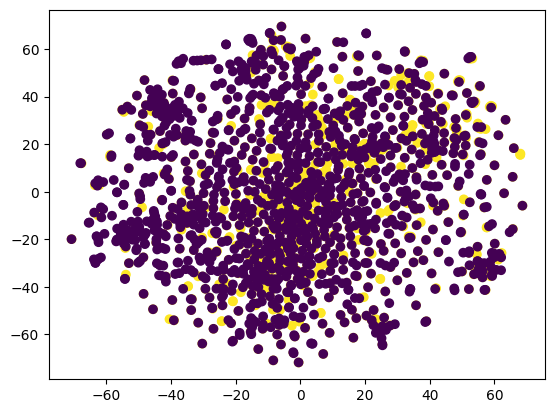

In [5]:
# t-SNE Visualization
tsne_embeds = TSNE(n_components=2).fit_transform(feats)
dim1, dim2 = zip(*tsne_embeds)
plt.scatter(dim1, dim2, c=labels_encoded, cmap='viridis')
plt.show()

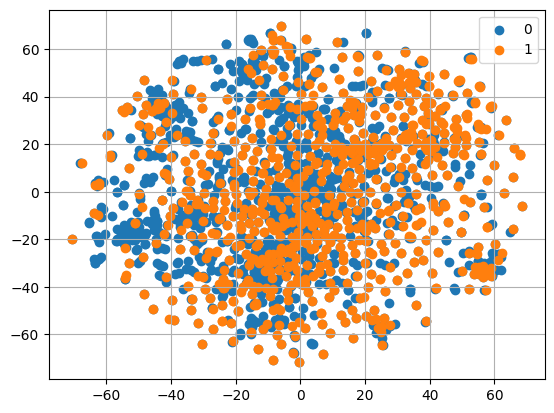

In [6]:
def plotting(voice_tsne, labels):#face_tsne, labels):
    ax = plt.subplot()

    groups = pd.DataFrame(voice_tsne, columns=['x', 'y']).assign(category=labels).groupby('category')
    for name, points in groups:
        ax.scatter(points.x, points.y, marker='o', label=name)

    # groups = pd.DataFrame(face_tsne, columns=['x', 'y']).assign(category=labels).groupby('category')
    # for name, points in groups:
    #     ax.scatter(points.x, points.y, marker='x')

    ax.legend(bbox_to_anchor=(1, 1))
    plt.grid()
    plt.show()

# Plotting t-SNE Visualization
plotting(zip(dim1, dim2), labels)

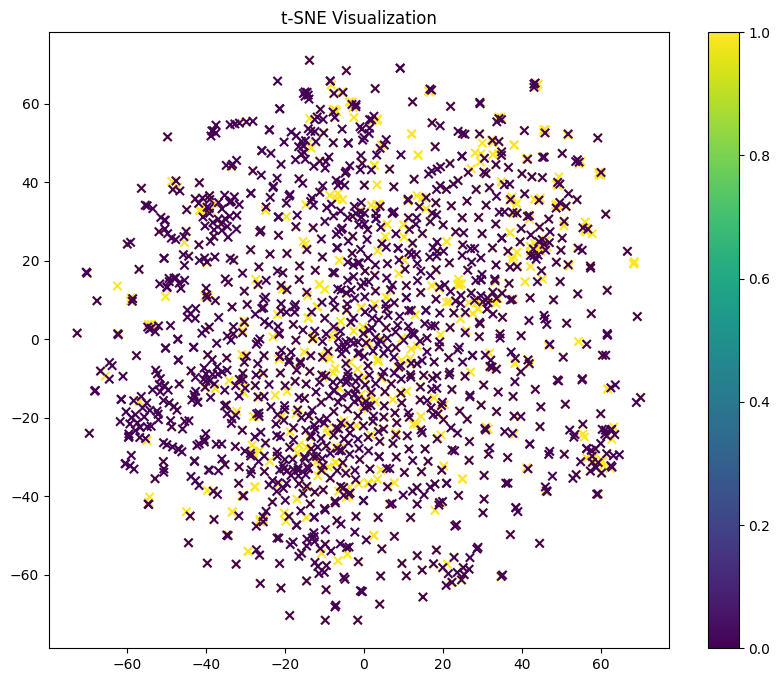

In [7]:
def plotting(tsne_embeds, labels):
    plt.figure(figsize=(10, 8))
    plt.scatter(tsne_embeds[:, 0], tsne_embeds[:, 1], c=labels, cmap='viridis', marker='x')
    plt.colorbar()
    plt.title('t-SNE Visualization')
    plt.show()

# t-SNE Visualization
tsne_embeds = TSNE(n_components=2).fit_transform(feats)

# Plotting t-SNE Visualization
plotting(tsne_embeds, labels)

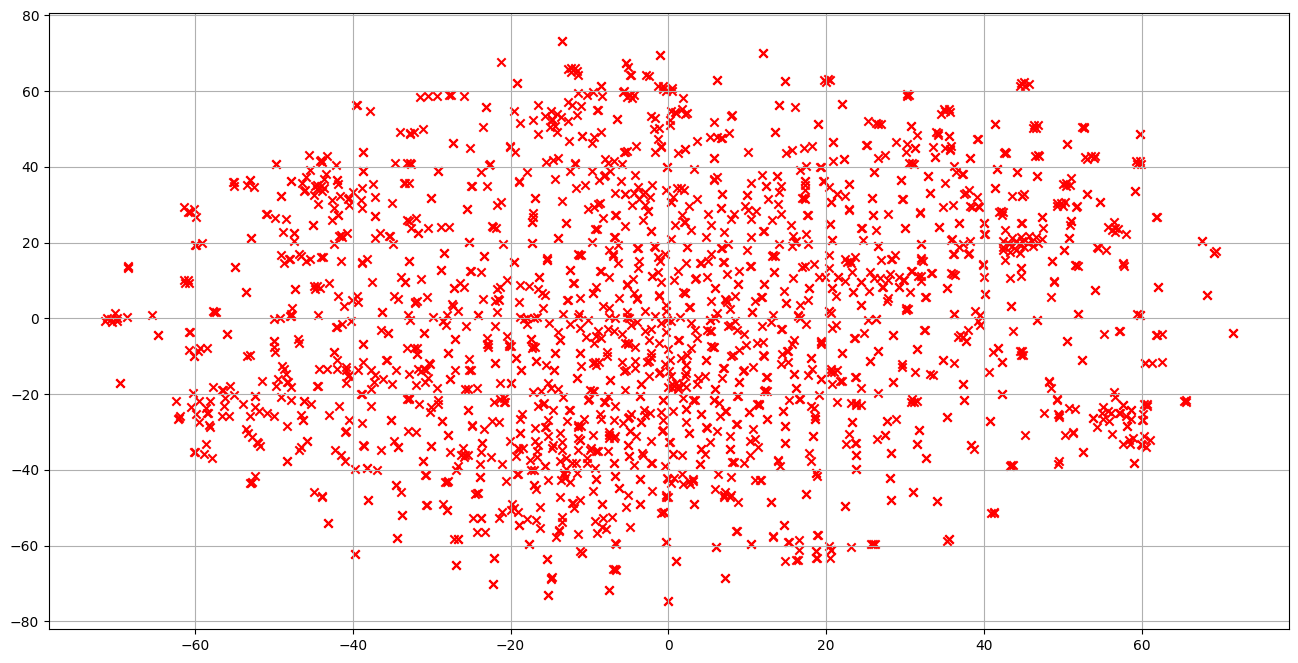

In [9]:

tsne_embeds = TSNE(n_components=2).fit_transform(feats)
color = list(colors._colors_full_map.values())
dim1, dim2 = zip(*tsne_embeds)

fig = plt.figure(figsize=(16, 8))
plt.scatter(dim1, dim2, color = 'red', marker='x')
plt.savefig('cl_1.0.png')
plt.grid()
plt.show()

# New Section

In [1]:
import pandas as pd
import numpy as np
from scipy.io import loadmat
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.manifold import TSNE
from matplotlib import colors
import matplotlib.pyplot as plt


def svm(feats, labels, mod):
    xtrain,xtest,ytrain,ytest = train_test_split(feats,labels,test_size=0.2)
    model = SVC(kernel='linear')
    model.fit(xtrain,ytrain)
    print('Predicting')
    pred = model.predict(xtest)
    print(mod+" Accuracy:",metrics.accuracy_score(ytest, pred))

def tsne(feats):
    tsne_embeds = TSNE(n_components=2).fit_transform(feats)
    dim1, dim2 = zip(*tsne_embeds)
    return dim1, dim2, tsne_embeds

def plotting(voice_tsne, face_tsne, labels):
    ax = plt.subplot()

    groups = pd.DataFrame(voice_tsne, columns=['x', 'y']).assign(category=labels).groupby('category')
    for name, points in groups:
        ax.scatter(points.x, points.y, marker='o', label=name)

    groups = pd.DataFrame(face_tsne, columns=['x', 'y']).assign(category=labels).groupby('category')
    for name, points in groups:
        ax.scatter(points.x, points.y, marker='x')

    ax.legend(bbox_to_anchor = (1,1))
    # leg_labels = [str(i) for i in range(10)]
    # leg_labels = np.asarray(leg_labels)
    # color = list(colors._colors_full_map.values())
    # color = color[0:len(leg_labels)]
    # plt.scatter(vDim1, vDim2, marker = 'o', c=labels, cmap=colors.ListedColormap(color), label = 'voice')#c=labels, cmap=colors.ListedColormap(color)) #color='red'
    # plt.scatter(fDim1, fDim2, marker = 'x', c=labels, cmap=colors.ListedColormap(color), label = 'face')#c=labels, cmap=colors.ListedColormap(color)) #color='green'
    # plt.legend(loc='upper left', bbox_to_anchors = (1,1))
    plt.savefig('aaa.png', dpi=1200, bbox_inches = 'tight')
    plt.grid()
    plt.show()


In [2]:

# test_voice_feats = 'E:/UETGen/2/train_test/voiceTest.csv'
# test_voice_labels = 'D:/learnablePins/voiceFilesTest.txt'
# voice_feats, labels, featPerId = read_voice_data(test_voice_feats, test_voice_labels, 10)
# face_feats = read_face_data(featPerId)

# le = preprocessing.LabelEncoder()
# le.fit(labels)
# labels = le.transform(labels)

# svm(voice_feats, labels, mod = 'voice')
# svm(face_feats, labels, mod= 'face')

# voiceDim1, voiceDim2 = tsne(voice_feats)
# faceDim1, faceDim2 = tsne(face_feats)

# plotting(voiceDim1, voiceDim2, faceDim1, faceDim2)

    # break
face_test = pd.read_csv('/content/hateful-train+test_unseen/test.csv', header=None)
# voice_test = pd.read_csv('E:/UETGen/2/train_test/voiceTrain.csv', header=None)
filename = '/content/hateful-train+test_unseen/file_paths.txt'

face_test = face_test.iloc[1:]
# voice_test = voice_test.iloc[1:]

# In[1]

# face_test =
labels = []
count = 0
counter = 0
prev = 10002
face_feats = []
# voice_feats = []
feats = []
with open(filename, 'r+') as f:
    for i, dat in enumerate(f):
        if counter>50:
            break
        if count%2 == 0:
            curr = dat.split('\n')[0].split('/')[0].split('id')[1]
            face_feats.append(face_test.iloc[i].to_numpy())
            # voice_feats.append(voice_test.iloc[i].to_numpy())
            labels.append(curr)
            if curr!=prev:
                prev = curr
                counter+=1
            count=1
        else:
            count = 0
labels = np.asarray(labels[:-1])
# voice_feats = np.asarray(voice_feats[:-1])
face_feats = np.asarray(face_feats[:-1])



IndexError: ignored

In [ ]:

# feats = feats[:-1]
# feats = np.asarray(feats)
# labels = np.asarray(labels)

le = preprocessing.LabelEncoder()
le.fit(labels)
labels = le.transform(labels)

svm(voice_feats, labels, mod = 'voice')
svm(face_feats, labels, mod= 'face')

# voiceDim1, voiceDim2, voice_tsne = tsne(voice_feats)
# faceDim1, faceDim, face_tsne = tsne(face_feats)

# plotting(voice_tsne, face_tsne, labels)

# xtrain,xtest,ytrain,ytest = train_test_split(feats,labels,test_size=0.2)
# model = SVC(kernel='linear')
# model.fit(xtrain,ytrain)
# print('Predicting')
# pred = model.predict(xtest)

# print("Accuracy:",metrics.accuracy_score(ytest, pred))



# tsne_embeds = TSNE(n_components=2).fit_transform(feats)
# color = list(colors._colors_full_map.values())
# dim1, dim2 = zip(*tsne_embeds)

# fig = plt.figure(figsize=(16, 8))
# plt.scatter(dim1, dim2, color = 'red', marker='x')
# plt.savefig('cl_1.0.png')
# plt.grid()
# plt.show()

Accuracy: 0.61


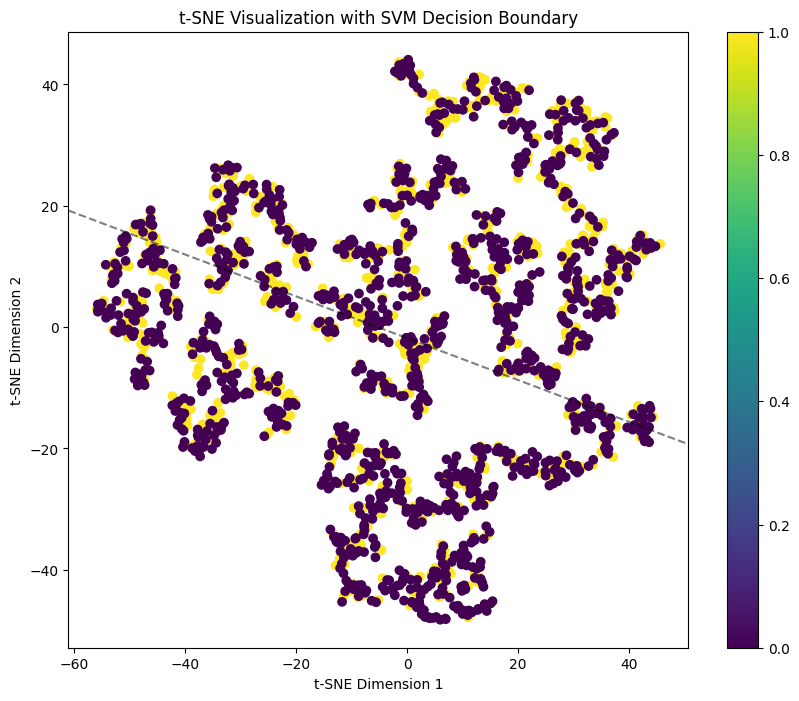

In [6]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Load features from CSV
features_file = '/content/hateful-train+test_unseen/test.csv'  # Replace with the actual file path
feats = pd.read_csv(features_file, header=None)

# Load image paths and extract labels
image_paths_file = '/content/hateful-train+test_unseen/file_paths.txt'  # Replace with the actual file path
with open(image_paths_file, 'r') as f:
    image_paths = [line.strip() for line in f]

# Extract labels from image paths (assuming the label is the last directory name)
labels = [int(path.split('/')[-2]) for path in image_paths]

# Preprocessing
labels_encoded = preprocessing.LabelEncoder().fit_transform(labels)

# Dimensionality Reduction using PCA
pca = PCA(n_components=2)
feats_reduced = pca.fit_transform(feats)

# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(feats_reduced, labels_encoded, test_size=0.2, random_state=42)

# SVM Classification
model = SVC(kernel='linear')
model.fit(x_train, y_train)
pred = model.predict(x_test)
accuracy = model.score(x_test, y_test)
print(f"Accuracy: {accuracy:.2f}")

# t-SNE Visualization
tsne_embeds = TSNE(n_components=2).fit_transform(feats_reduced)

# Scatter plot with t-SNE embeddings and SVM decision boundary
plt.figure(figsize=(10, 8))
plt.scatter(tsne_embeds[:, 0], tsne_embeds[:, 1], c=labels_encoded, cmap='viridis', marker='o')
plt.colorbar()
plt.title('t-SNE Visualization with SVM Decision Boundary')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')

# Plot SVM decision boundary
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Create grid to evaluate model
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 100), np.linspace(ylim[0], ylim[1], 100))
Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundary and margins
ax.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])

plt.show()
